In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [14]:
def draw_trajectory(transforms_path, ax, color='r', size=20):
    plt.style.use('seaborn-whitegrid')
    legend_flag = False

    with open(transforms_path, 'r', encoding='utf-16') as json_file:
        contents = json.load(json_file)
        fovx = contents["camera_angle_x"]
        frames = contents["Frames"]

        for idx, frame in enumerate(frames):
            if idx % 60 != 0:
                continue
            file_path = os.path.split(frame['file_path'])[-1]
            # transform a to list
            c2w = frame['transform_matrix']
            c2w = c2w.replace('[', '').replace(']', '').replace(',', '').split(' ')
            c2w = [float(i) for i in c2w if i != '']
            c2w = np.array(c2w).reshape(4, 4).T
            c2w[:3, 3] = c2w[:3, 3] / 100  # cm to m

            pos = c2w[:3, 3]  # camera center position
            x_dir = c2w[:3, 0] / (np.linalg.norm(c2w[:3, 0]) + 1e-8)
            y_dir = c2w[:3, 1] / (np.linalg.norm(c2w[:3, 1]) + 1e-8)
            z_dir = c2w[:3, 2] / (np.linalg.norm(c2w[:3, 2]) + 1e-8)
            a = pos + size * x_dir + size * y_dir + size * z_dir
            b = pos - size * x_dir + size * y_dir + size * z_dir
            c = pos - size * x_dir - size * y_dir + size * z_dir
            d = pos + size * x_dir - size * y_dir + size * z_dir

            dir = (a + b + c + d) / 4 - pos  # camera view direction, i.e. z-axis
            dir = dir / (np.linalg.norm(dir) + 1e-8)
            o = pos + dir * 3

            ax.arrow(pos[1], pos[0], size * x_dir[1], size * x_dir[0], color='r', head_width=size/2, label='x-axis')
            ax.arrow(pos[1], pos[0], size * y_dir[1], size * y_dir[0], color='g', head_width=size/2, label='y-axis')
            # ax.arrow(pos[2], pos[0], size * z_dir[2], size * z_dir[0], color='b', head_width=size/20000, label='z-axis')
            if not legend_flag:
                ax.legend()
                legend_flag = True

    ax.axis('equal')
    ax.set_xlabel('y/m')
    ax.set_ylabel('x/m')

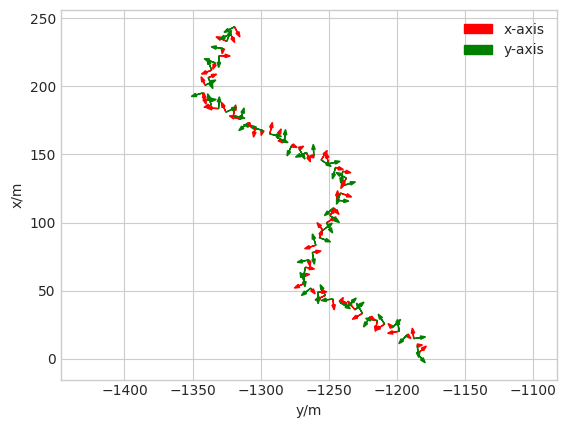

In [18]:
# data_path, subset = '../data/UE-collected', 'vehicle-train-20231114'
data_path, subset = '../data/UE-collected', 'vehicle-test-20231115'
transforms_path = os.path.join(data_path, subset, 'transforms.json')
fig = plt.figure()
ax = fig.gca()
draw_trajectory(transforms_path, ax, color='r', size=5)
plt.show()

In [11]:
transforms_path_ref = os.path.join(data_path, subset, 'transforms_ref.json')
out_contents = {}
with open(transforms_path_ref) as json_file:
    ref_contents = json.load(json_file)
with open(transforms_path, 'r', encoding='utf-16') as json_file:
    contents = json.load(json_file)
    contents['Sensor_Width'] = 23.76  # mm
    contents['Sensor_Height'] = 13.365  # mm
    contents['Current_Focal_Length'] = 11.8  # mm
    contents['camera_angle_x'] = 90.387123 * np.pi / 180  # degree to rad

# initialize out_contents with the same keys as ref_contents
for key in ref_contents.keys():
    if key == 'frames':
        out_contents[key] = []
    else:
        out_contents[key] = 0

out_contents['camera_angle_x'] = contents['camera_angle_x']
out_contents['cx'] = contents['cx']
out_contents['cy'] = contents['cy']
out_contents['w'] = contents['w']
out_contents['h'] = contents['h']
out_contents['fl_x'] = contents['w'] / contents['Sensor_Width'] * contents['Current_Focal_Length']
out_contents['fl_y'] = contents['h'] / contents['Sensor_Height'] * contents['Current_Focal_Length']
camera_angle_x = np.arctan(0.5 * contents['Sensor_Width'] / contents['Current_Focal_Length']) * 2

frames = contents["Frames"]
for idx, frame in enumerate(frames):
    c2w = frame['transform_matrix']
    c2w = c2w.replace('[', '').replace(']', '').replace(',', '').split(' ')
    c2w = [float(i) for i in c2w if i != '']
    c2w = np.array(c2w).reshape(4, 4).T
    c2w[:3, 3] = c2w[:3, 3] / 100  # cm to m

    c2w_gs = np.zeros((4, 4))
    c2w_gs[:3, 3] = c2w[:3, 3]
    c2w_gs[:3, 0] = c2w[:3, 1]
    c2w_gs[:3, 1] = c2w[:3, 2]
    c2w_gs[:3, 2] = -c2w[:3, 0]
    file_path = os.path.join(subset, os.path.split(frame['file_path'])[-1])
    out_contents['frames'].append({'file_path': file_path, 'transform_matrix': c2w_gs.tolist()})

transforms_path_out = os.path.join(data_path, subset, 'transforms_train.json')
with open(transforms_path_out, 'w') as json_file:
    json.dump(out_contents, json_file, indent=4)

print('Here')

Here
